In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# !pip install tldextract
!pip install fasttext
# !pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 834.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199770 sha256=2cf192992ce2fa45857d613c45ca9182d8a04ba267dbde67d1096c08600de591
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [3]:
from urllib.parse import urlparse
# import tldextract

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, RobertaForSequenceClassification
import fasttext
import fasttext.util
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
# from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout, Input, Concatenate
from keras.regularizers import l1, l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model

In [ ]:
phish_df = pd.read_csv('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/dataset/phishtank_data_corpus_complete_15-07-23.csv')
nonphish_df = pd.read_csv('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/dataset/original_website_dataset.csv')

In [ ]:
phish_df.head()

,id,url,is_valid,phishing_url,submission_time
0,8225238,https://phishtank.org/phish_detail.php?phish_i...,Unknown,https://pocztapolsk.buzz/pay,Jul 15th 2023 9:45 AM
1,8225237,https://phishtank.org/phish_detail.php?phish_i...,VALID PHISH,https://alertsuser.github.io/pantek/kimax/,Jul 15th 2023 9:38 AM
2,8225236,https://phishtank.org/phish_detail.php?phish_i...,Unknown,https://digicamforums.com,Jul 15th 2023 9:19 AM
3,8225235,https://phishtank.org/phish_detail.php?phish_i...,Unknown,SPAMs://wirelessworldshop.com/,Jul 15th 2023 9:19 AM
4,8225234,https://phishtank.org/phish_detail.php?phish_i...,Unknown,SPAMs://www.wirelessworldshop.com,Jul 15th 2023 9:19 AM


In [ ]:
nonphish_df.head()

,url,Speical_Char,Have_IP,Have_At,URL_length,URL_Depth,redirection,time_get_redirect,port_in_url,use_http,...,unescape,escape,ActiveXObject,fromCharCode,atob,Punny_Code,TLDs,Title,country_name,label
0,https://sites.google.com/site/policyclaming76745/,3,0,0,0,2,6,0,0,0,...,0,0,0,0,0,0,com,Google Sites,US,1
1,https://www.pinterest.com/abbiestever/?redirec...,5,0,0,0,1,6,0,0,0,...,0,0,0,0,0,0,com,Abbie Roose Stever (abbiestever) - Profile | P...,NaN,0
2,https://www.pinterest.com/abiolatv/bombshell-g...,3,0,0,1,2,6,0,0,0,...,0,0,0,0,0,0,com,No Title,NaN,0
3,https://balajipackersguntur.com/images/,2,0,0,0,1,6,0,0,0,...,0,0,0,0,0,0,com,Index of /images,IN,1
4,https://sites.google.com/site/claming564336670...,3,0,0,0,2,6,0,0,0,...,0,0,0,0,0,0,com,SECURITY,NaN,1


In [ ]:
phish_df.shape, nonphish_df.shape

((99923, 5), (167872, 32))

### df merge

#### Label

phishing: -1\
genuine: 1

In [ ]:
phish_df['phishing_url']==''

0        False
1        False
2        False
3        False
4        False
         ...  
99918    False
99919    False
99920    False
99921    False
99922    False
Name: phishing_url, Length: 99923, dtype: bool

In [ ]:
df_1 = pd.DataFrame({'url': phish_df['phishing_url'], 'label': -1*np.ones(phish_df.shape[0])})
df_2 = pd.DataFrame({'url': nonphish_df.sample(phish_df.shape[0])['url'], 'label': np.ones(phish_df.shape[0])})

In [ ]:
df = pd.concat([df_1, df_2]).sample(frac=1, ignore_index=True)

In [ ]:
df.head()

,url,label
0,https://pub-2be8d85524fd4d819dc501adaa06c260.r...,-1.0
1,https://storage.googleapis.com/hatrioua/hrefli...,-1.0
2,http://www.famipay.famldlgli.01477.cn/,-1.0
3,https://care-net.org,1.0
4,https://apaci.com.au,1.0


### data cleaning

In [ ]:
def filter_df(x):
    try:
        scheme = urlparse(str(x))._asdict()['netloc']
        if scheme=='':
            return np.nan
        return x
    except:
        scheme = urlparse(str(x)[:-1])._asdict()['netloc']
        if scheme=='':
            return np.nan
        return x

In [ ]:
df.shape

(199846, 2)

In [ ]:
df['url'] = df['url'].apply(lambda x: filter_df(x))
df.dropna(inplace=True)

In [ ]:
df.shape

(199690, 2)

In [ ]:
urlparse(df['url'][1])._asdict(), urlparse('http://198.50.135.149:80/redirecionamento/tv55lgm.php')._asdict()

({'scheme': 'https',
  'netloc': 'storage.googleapis.com',
  'path': '/hatrioua/hreflink.html',
  'params': '',
  'query': '',
  'fragment': '?Z289MSZzMT0xNjQzNzQ4JnMyPTE4ODQwNTQxNyZzMz1HTEI='},
 {'scheme': 'http',
  'netloc': '198.50.135.149:80',
  'path': '/redirecionamento/tv55lgm.php',
  'params': '',
  'query': '',
  'fragment': ''})

In [ ]:
def parser(x, key, type):
    try:
        scheme = urlparse(str(x))._asdict()[key]
    except:
        scheme = urlparse(str(x)[:-1])._asdict()[key]

    return pd.Series([scheme], index=[type])


def parse_domain(x):
    subdomain = None
    domain = None
    tld = None
    try:
        scheme = urlparse(str(x))._asdict()['netloc']
        url = tldextract.extract(scheme)
        subdomain, domain, tld = url.subdomain, url.domain, url.suffix
    except:
        scheme = urlparse(str(x)[:-1])._asdict()['netloc']
        url = tldextract.extract(scheme)
        subdomain, domain, tld = url.subdomain, url.domain, url.suffix

    return pd.Series([subdomain, domain, tld], index=['subdomain', 'domain', 'tld'])

In [ ]:
df_protocol = df['url'].apply(lambda x: parser(x, 'scheme', 'protocol'))
df_domain = df['url'].apply(lambda x: parse_domain(x))
df_path = df['url'].apply(lambda x: parser(x, 'path', 'path'))
df_url_length = df['url'].apply(lambda x: len(x)).rename('url_length')

In [ ]:
df_domain.head()

,subdomain,domain,tld
0,pub-2be8d85524fd4d819dc501adaa06c260,r2,dev
1,storage,googleapis,com
2,www.famipay.famldlgli,01477,cn
3,,care-net,org
4,,apaci,com.au


In [ ]:
df_protocol.head()

,protocol
0,https
1,https
2,http
3,https
4,https


In [ ]:
df_path.head()

,path
0,/autox.html
1,/hatrioua/hreflink.html
2,/
3,
4,


In [ ]:
df.shape, df_protocol.shape, df_domain.shape, df_path.shape, df_url_length.shape

((199690, 2), (199690, 1), (199690, 3), (199690, 1), (199690,))

In [ ]:
df.head()

,url,label
0,https://pub-2be8d85524fd4d819dc501adaa06c260.r...,-1.0
1,https://storage.googleapis.com/hatrioua/hrefli...,-1.0
2,http://www.famipay.famldlgli.01477.cn/,-1.0
3,https://care-net.org,1.0
4,https://apaci.com.au,1.0


In [ ]:
filtered_df = pd.concat([df_protocol, df_domain, df_path, df_url_length, df], axis=1)

In [ ]:
filtered_df.head()

,protocol,subdomain,domain,tld,path,url_length,url,label
0,https,pub-2be8d85524fd4d819dc501adaa06c260,r2,dev,/autox.html,62,https://pub-2be8d85524fd4d819dc501adaa06c260.r...,-1.0
1,https,storage,googleapis,com,/hatrioua/hreflink.html,103,https://storage.googleapis.com/hatrioua/hrefli...,-1.0
2,http,www.famipay.famldlgli,01477,cn,/,38,http://www.famipay.famldlgli.01477.cn/,-1.0
3,https,,care-net,org,,20,https://care-net.org,1.0
4,https,,apaci,com.au,,20,https://apaci.com.au,1.0


In [ ]:
filtered_df['protocol'].value_counts()

https     168614
http       30824
spams        226
spam          21
hxxps          3
ttps           1
-hxxps         1
Name: protocol, dtype: int64

In [ ]:
filtered_df['tld'].value_counts()

com       98631
org       12654
io         6950
net        5886
ru         5148
          ...  
gov.do        1
nagoya        1
pizza         1
com.sl        1
gov.mo        1
Name: tld, Length: 926, dtype: int64

In [ ]:
processed_urls = filtered_df[['protocol', 'subdomain', 'domain', 'tld']].apply(' '.join, axis=1)

In [ ]:
processed_url_df = pd.DataFrame({'processed_url': processed_urls, 'url_length': filtered_df['url_length'], 'label': filtered_df['label'] })

In [ ]:
processed_url_df.head()

,processed_url,url_length,label
0,https pub-2be8d85524fd4d819dc501adaa06c260 r2 dev,62,-1.0
1,https storage googleapis com,103,-1.0
2,http www.famipay.famldlgli 01477 cn,38,-1.0
3,https care-net org,20,1.0
4,https apaci com.au,20,1.0


In [ ]:
processed_url_df['label'].value_counts()

 1.0    99923
-1.0    99767
Name: label, dtype: int64

In [ ]:
# 0 -> phishing
# 1 -> non-phishing
processed_url_df['label'].replace(-1, 0, inplace=True)

In [ ]:
processed_url_df['label'].value_counts()

1.0    99923
0.0    99767
Name: label, dtype: int64

In [ ]:
processed_url_df['processed_url'] = processed_url_df['processed_url'].apply(lambda x: x.lower())

In [ ]:
processed_url_df.head()

,processed_url,url_length,label
0,https pub-2be8d85524fd4d819dc501adaa06c260 r2 dev,62,0.0
1,https storage googleapis com,103,0.0
2,http www.famipay.famldlgli 01477 cn,38,0.0
3,https care-net org,20,1.0
4,https apaci com.au,20,1.0


In [4]:
# processed_url_df.to_csv('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/processed_urls.csv', index=False)
processed_url_df = pd.read_csv('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/processed_urls.csv')

In [5]:
processed_url_df['url_length'] = (processed_url_df['url_length']-processed_url_df['url_length'].min())/(processed_url_df['url_length'].max()-processed_url_df['url_length'].min())

In [6]:
train, test = train_test_split(processed_url_df, test_size=0.3, random_state=42)

In [7]:
train.shape, test.shape

((139783, 3), (59907, 3))

In [8]:
train.head()

,processed_url,url_length,label
168841,http www.appieid us com,0.005192,1.0
185551,http paypal.co.uk.userpp237nw85sj settingsppup...,0.010878,1.0
24917,http tut5 rf gd,0.004450,1.0
137889,https ultraedit com,0.002225,1.0
177931,https zipgenius it,0.001978,1.0


In [9]:
url_length_train = train['url_length'].values
url_length_test = test['url_length'].values

In [10]:
url_length_train.shape, url_length_test.shape

((139783,), (59907,))

In [11]:
ft = fasttext.load_model('drive/MyDrive/Semester/MTP/Phishing-Detection/cc.en.300.bin')

In [12]:
# fasttext.util.reduce_model(ft, 150)

In [13]:
ft.get_dimension()

300

In [14]:
MAX_SEQUENCE_LENGTH = 4
EMBEDDING_DIM = ft.get_dimension()

In [15]:
all_sentences = pd.concat([train, test], axis=0)
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(all_sentences['processed_url'])
sequences = tokenizer.texts_to_sequences(all_sentences['processed_url'])
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')

## creating embedding matrix

In [16]:
vocab_size = len(word_index) + 1
embedding_matrix = np.random.random((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = None
    try:
        embedding_vector = ft.get_word_vector(word)
    except Exception as e:
        print(word, 'not found', e)
    if embedding_vector is not None:
        embedding_matrix[i, :] = embedding_vector

## build model

In [25]:
def build_model():
    sentence_indices = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')

    embeddings = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(sentence_indices)

    X = Bidirectional(LSTM(units = 32, kernel_regularizer=l1(1e-6), return_sequences = True))(embeddings)   #, dropout=0.05, recurrent_dropout=0.15 , return_sequences = True
    X = Dropout(rate = 0.4)(X)
    # X = Bidirectional(LSTM(units = 16, kernel_regularizer=l1(1e-6), return_sequences = True))(X)   #, dropout=0.05, recurrent_dropout=0.15 , return_sequences = True
    # X = Dropout(rate = 0.2)(X)
    X = Bidirectional(LSTM(units = 16, kernel_regularizer=l1(1e-6)))(X)   #, dropout=0.05, recurrent_dropout=0.15 , return_sequences = True
    X = Dropout(rate = 0.2)(X)
    #X = GlobalMaxPooling1D()(X)
    # X = Dense(4, activation='relu')(X)
    ip2 = Input(shape=(1,), dtype='float32')
    concat = Concatenate()([X, ip2])
    op = Dense(2, activation='relu')(concat)
    op = Dense(1, activation='sigmoid')(op)

    model = Model(inputs=[sentence_indices, ip2], outputs=op)

    return model

In [26]:
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 4, 300)       40812900    ['input_3[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 4, 64)       85248       ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 dropout_2 (Dropout)            (None, 4, 64)        0           ['bidirectional_2[0][0]']  

In [27]:
train_data = data[:train.shape[0]]
test_data = data[train.shape[0]:]
print(train_data.shape, test_data.shape)

(139783, 4) (59907, 4)


In [28]:
train_data

array([[    4, 11203,    67,     2],
       [   21, 28846,  5247,     2],
       [    3, 28847,   647,   134],
       ...,
       [    3,   204,     2,     0],
       [  222, 18741,   216,    58],
       [    1,    50,     5,     2]], dtype=int32)

In [29]:
X_train, Y_train = train_data, train['label'].values
X_test, Y_test = test_data, test['label'].values

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001, verbose=1)

history = model.fit([X_train, url_length_train], Y_train, batch_size=64, epochs=100, validation_split= 0.1, callbacks=[earlyStopping])

Epoch 1/100
1966/1966 [==============================] - 56s 23ms/step - loss: 0.4672 - accuracy: 0.8097 - val_loss: 0.4096 - val_accuracy: 0.8353
Epoch 2/100
1966/1966 [==============================] - 44s 22ms/step - loss: 0.3965 - accuracy: 0.8403 - val_loss: 0.3814 - val_accuracy: 0.8451
Epoch 3/100
1966/1966 [==============================] - 44s 22ms/step - loss: 0.3685 - accuracy: 0.8502 - val_loss: 0.3661 - val_accuracy: 0.8497
Epoch 4/100
1966/1966 [==============================] - 44s 23ms/step - loss: 0.3523 - accuracy: 0.8563 - val_loss: 0.3512 - val_accuracy: 0.8546
Epoch 5/100
1966/1966 [==============================] - 43s 22ms/step - loss: 0.3402 - accuracy: 0.8607 - val_loss: 0.3403 - val_accuracy: 0.8607
Epoch 6/100
1966/1966 [==============================] - 42s 21ms/step - loss: 0.3308 - accuracy: 0.8639 - val_loss: 0.3357 - val_accuracy: 0.8618
Epoch 7/100
1966/1966 [==============================] - 41s 21ms/step - loss: 0.3230 - accuracy: 0.8683 - val_loss: 0

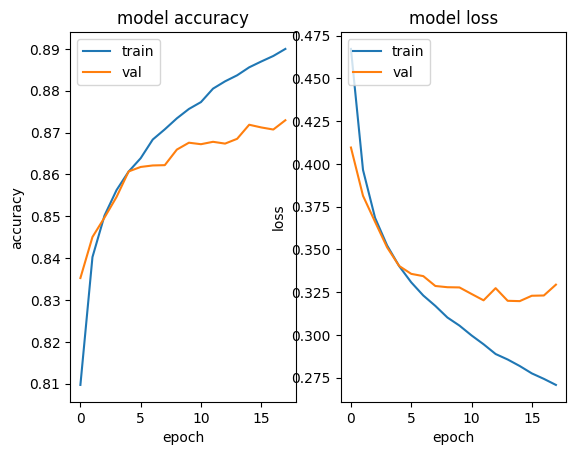

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')

plt.show()

In [32]:
accr = model.evaluate([X_test, url_length_test], Y_test, batch_size=64)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

937/937 [==============================] - 8s 8ms/step - loss: 0.3224 - accuracy: 0.8742
Test set
  Loss: 0.322
  Accuracy: 0.874
